# Example Comparison Code

In [16]:
import numpy as np
import json
import os
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from Py6S import *

mi.set_variant("llvm_ad_rgb_double")

In [17]:
red='#E06666'
green='#9DBB53'
blue='#78C7FF'

In [18]:
def relative_diff(a, b):
    '''if np.abs(a - b) < 1e-6:
        return 0
    return (a - b) / b'''
    result = np.zeros_like(a)
    for i in range(len(a)):
        if np.abs(a[i] - b[i]) < 1e-6:
            result[i] = 0
        else:
            result[i] = (a[i] - b[i]) / b[i]
    return result

def simple_diff(a, b):
    return a - b

def abs_diff(a, b):
    return np.abs(a - b)

def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

In [19]:
# Ocean parameters
wavelength = 2.2
wind_speed = 0.1
wind_direction = 0
salinity = 34.3
pigmentation = 0.3

# Set up the solar zenith angle
solar_zenith = 0
solar_azimuth = 0

outgoing_zeniths = np.arange(0, 86, 5)
outgoing_azimuth = 180

In [20]:
# SixS Simulation
s = SixS()
s.aero_profile = AeroProfile.PredefinedType(AeroProfile.NoAerosols)
s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.NoGaseousAbsorption)
s.ground_reflectance = GroundReflectance.HomogeneousOcean(wind_speed, wind_direction, salinity, pigmentation)

# Use a relatively small offet to avoid numerical issues with the SixS model... 
s.wavelength = Wavelength(wavelength)

results = {}
total_reflectance = {}
foam_values = {}
glint_values = {}
water_values = {}
foam_percentages = {}
glint_percentages = {}
water_percentages = {}
idx = 0
max_idx = len(outgoing_zeniths)

# Run simulations for every viewing zenith
for viewing_zenith in outgoing_zeniths:
    s.geometry = Geometry.User()
    s.geometry.solar_z = solar_zenith
    s.geometry.solar_a = solar_azimuth
    s.geometry.view_z = viewing_zenith
    s.geometry.view_a = outgoing_azimuth
    s.run()

    foam = s.outputs.values['water_component_foam']
    glint = s.outputs.values['water_component_glint']
    water = s.outputs.values['water_component_water']
    total = foam + glint + water
    total_reflectance[viewing_zenith] = total
    results[viewing_zenith] = [foam, glint, water]
    if total < 1e-6:
        foam_values[viewing_zenith] = 0
        glint_values[viewing_zenith] = 0
        water_values[viewing_zenith] = 0
        foam_percentages[viewing_zenith] = 0
        glint_percentages[viewing_zenith] = 0
        water_percentages[viewing_zenith] = 0
    else:
        foam_values[viewing_zenith] = foam
        glint_values[viewing_zenith] = glint
        water_values[viewing_zenith] = water
        foam_percentages[viewing_zenith] = foam / total
        glint_percentages[viewing_zenith] = glint / total
        water_percentages[viewing_zenith] = water / total

    idx += 1
    print(f"Completed {idx}/{max_idx}")

outgoing_reflectances = []
foam = []
glint = []
water = []
for zenith in outgoing_zeniths:
    outgoing_reflectances.append(total_reflectance[zenith])
    foam.append(foam_values[zenith])
    glint.append(glint_values[zenith])
    water.append(water_values[zenith])

outgoing_reflectances = np.array(outgoing_reflectances)
foam = np.array(foam)
glint = np.array(glint)
water = np.array(water)

Completed 1/18
Completed 2/18
Completed 3/18
Completed 4/18
Completed 5/18
Completed 6/18
Completed 7/18
Completed 8/18
Completed 9/18
Completed 10/18
Completed 11/18
Completed 12/18
Completed 13/18
Completed 14/18
Completed 15/18
Completed 16/18
Completed 17/18
Completed 18/18


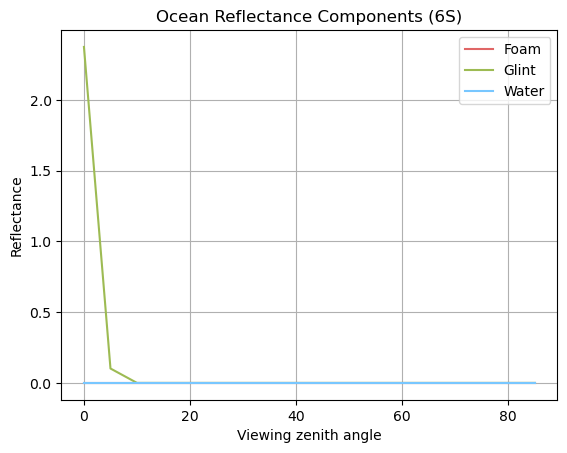

In [21]:
# Plot the results
import matplotlib.pyplot as plt

visualization_index = 0

# Plot the reflectance components in red, green and blue
plt.plot(outgoing_zeniths, foam, color=red)
plt.plot(outgoing_zeniths, glint, color=green)
plt.plot(outgoing_zeniths, water, color=blue)

plt.xlabel('Viewing zenith angle')
plt.ylabel('Reflectance')
plt.title('Ocean Reflectance Components (6S)')
plt.legend(['Foam', 'Glint', 'Water', 'Total'])
plt.grid()
plt.show()


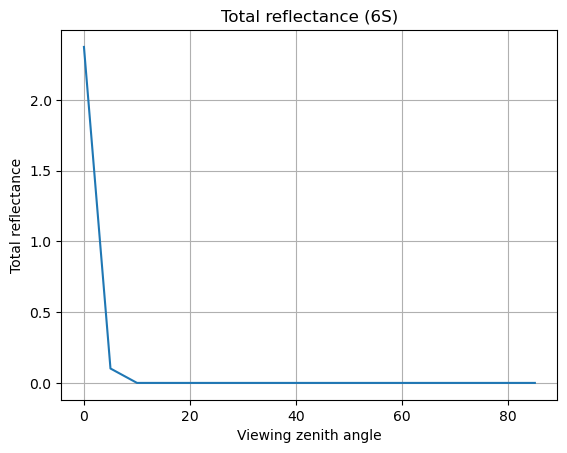

In [22]:
# Plot the total reflectance
plt.plot(outgoing_zeniths, [total_reflectance[zenith] for zenith in outgoing_zeniths])

plt.xlabel('Viewing zenith angle')
plt.ylabel('Total reflectance')
plt.title('Total reflectance (6S)')
plt.grid()
plt.show()

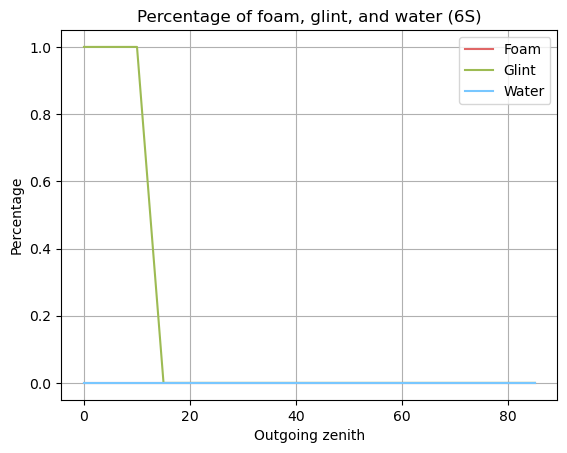

In [23]:
# Percentage of foam, glint, and water
fig, ax = plt.subplots()

foam_percent_data = foam_percentages.values()
glint_percent_data = glint_percentages.values()
water_percent_data = water_percentages.values()

ax.plot(outgoing_zeniths, foam_percent_data, label='Foam', color=red)
ax.plot(outgoing_zeniths, glint_percent_data, label='Glint', color=green)
ax.plot(outgoing_zeniths, water_percent_data, label='Water', color=blue)

ax.set(xlabel='Outgoing zenith', ylabel='Percentage',
            title=f'Percentage of foam, glint, and water (6S)')
ax.grid()
plt.legend()
plt.show()


In [24]:
WHITECAP=0
GLINT=1
UNDERLIGHT=2
TOTAL=3

channels = [WHITECAP, GLINT, UNDERLIGHT, TOTAL]

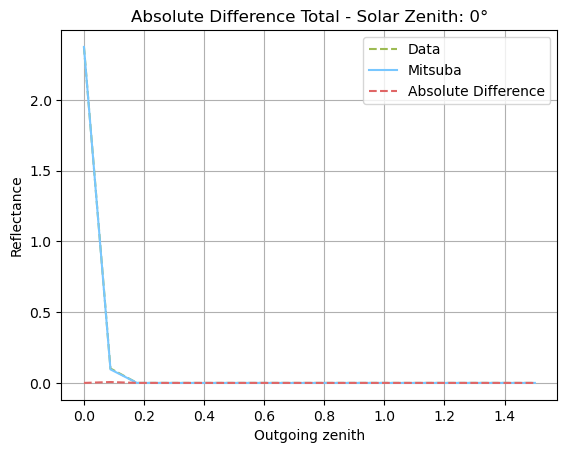

In [25]:
brdf_values = None
brdf_foam = None
brdf_glint = None
brdf_underlight = None

# Create a dummy surface interaction to use for the evaluation of the BSDF
si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with X degrees
si.wi = sph_to_eucl(np.deg2rad(solar_zenith), dr.deg2rad(0))

# Create grid in spherical coordinates and map it into a sphere
min_zenith = 0
max_zenith = 86

zenith_out = dr.linspace(mi.Float, min_zenith, np.deg2rad(max_zenith), len(outgoing_zeniths))
azimuth_out = dr.full(mi.Float, np.pi)

zeniths_o, azimuths_o = dr.meshgrid(
    zenith_out,
    azimuth_out,
)
wo = sph_to_eucl(zeniths_o, azimuths_o)

for channel in channels:
    bsdf = mi.load_dict({
        'type': 'oceanic_legacy',
        'channel': channel,
        'wavelength': wavelength,
        'wind_speed': wind_speed,
        'wind_direction': wind_direction,
        'chlorinity': 19,
        'pigmentation': 0.3
    })
    
    #result = bsdf.eval(mi.BSDFContext(), si, wo)
    if channel == WHITECAP:
        brdf_foam = bsdf.eval(mi.BSDFContext(), si, wo)
    elif channel == GLINT:
        brdf_glint = bsdf.eval(mi.BSDFContext(), si, wo)
    elif channel == UNDERLIGHT:
        brdf_underlight = bsdf.eval(mi.BSDFContext(), si, wo)
    elif channel == TOTAL:
        brdf_values = bsdf.eval(mi.BSDFContext(), si, wo)

# Evaluate the BSDF
bsdf_array = np.array(brdf_values)
foam_array = np.array(brdf_foam)
glint_array = np.array(brdf_glint)
underlight_array = np.array(brdf_underlight)

# Extract one channel
bsdf_array = bsdf_array[:, 0]
foam_array = foam_array[:, 0]
glint_array = glint_array[:, 0]
underlight_array = underlight_array[:, 0]

# Compute the difference between the data and the Mitsuba BSDF
reflectance_diff = abs_diff(outgoing_reflectances, bsdf_array)
foam_diff = abs_diff(foam, foam_array)
glint_diff = abs_diff(glint, glint_array)
underlight_diff = abs_diff(water, underlight_array)

# Plot against the outgoing zeniths
fig, ax = plt.subplots()
im = ax.plot(zeniths_o, outgoing_reflectances, label='Data', linestyle='--', color=green)
im = ax.plot(zeniths_o, bsdf_array, label='Mitsuba', linestyle='-', color=blue)
im = ax.plot(zeniths_o, reflectance_diff, label='Absolute Difference', linestyle='--', color=red)
ax.set(xlabel='Outgoing zenith', ylabel='Reflectance',
         title=f'Absolute Difference Total - Solar Zenith: {solar_zenith}°')
ax.grid()
ax.legend()
plt.show()

[2.37511402e+00 9.55811055e-02 4.98618488e-05 1.00156042e-10
 5.79075759e-11 5.79075759e-11 5.79075759e-11 5.79075759e-11
 5.79075759e-11 5.79075759e-11 5.79075759e-11 5.79075759e-11
 5.79075759e-11 5.79075759e-11 5.79075759e-11 5.79075759e-11
 5.79075759e-11 5.79075759e-11]
[2.37505e+00 1.01930e-01 6.00000e-05 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
[ 2.69555438e-05 -6.22868094e-02 -1.68969187e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


/var/folders/2y/rhmx4lpx7yj6c8p50ldw1x_c0000gp/T/ipykernel_45389/789970203.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(outgoing_zeniths)


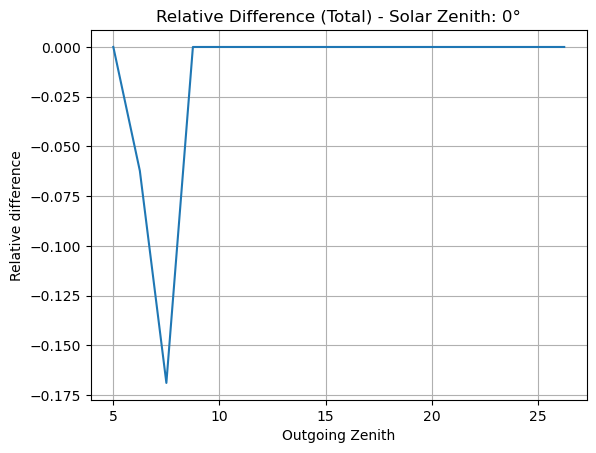

In [26]:
# Relative difference 
relative_diffs = relative_diff(bsdf_array, outgoing_reflectances)

print(bsdf_array)
print(outgoing_reflectances)
print(relative_diffs)

fig, ax = plt.subplots()
im = ax.plot(outgoing_zeniths, relative_diffs)
ax.set(xlabel='Outgoing Zenith', ylabel='Relative difference',
         title=f'Relative Difference (Total) - Solar Zenith: {solar_zenith}°')
ax.set_xticklabels(outgoing_zeniths)
ax.grid()
plt.show()

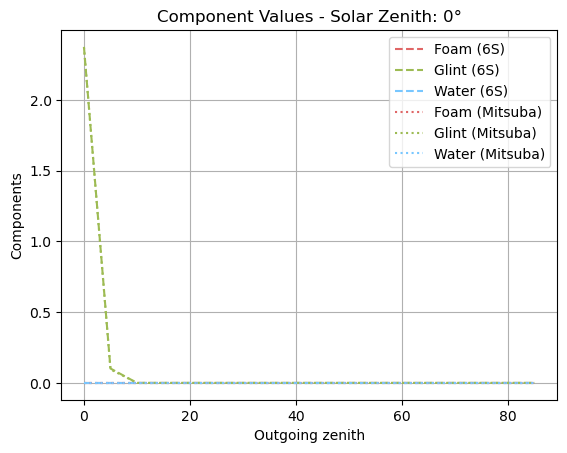

In [27]:
# Component-wise comparison of the BSDF
fig, ax = plt.subplots()

# Plot example foam, glint and underlight with dashed lines
im = ax.plot(outgoing_zeniths, foam, label='Foam (6S)', linestyle='--', color=red)
im = ax.plot(outgoing_zeniths, glint, label='Glint (6S)', linestyle='--', color=green)
im = ax.plot(outgoing_zeniths, water, label='Water (6S)', linestyle='--', color=blue)

# Plot the Mitsuba foam, glint and underlight with dotted lines
im = ax.plot(outgoing_zeniths, foam_array, label='Foam (Mitsuba)', linestyle=':', color=red)
im = ax.plot(outgoing_zeniths, glint_array, label='Glint (Mitsuba)', linestyle=':', color=green)
im = ax.plot(outgoing_zeniths, underlight_array, label='Water (Mitsuba)', linestyle=':', color=blue)

# Plot metadata
ax.set(xlabel='Outgoing zenith', ylabel='Components',
            title=f'Component Values - Solar Zenith: {solar_zenith}°')
ax.legend()
ax.grid()
plt.show()

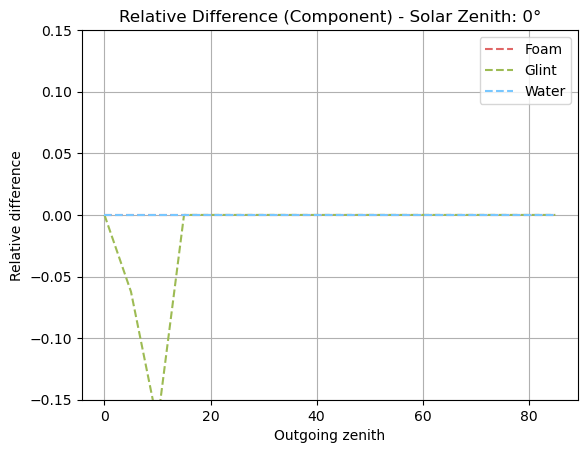

In [32]:
relative_foam_diffs = relative_diff(foam_array, foam)
relative_glint_diffs = relative_diff(glint_array, glint)
relative_underlight_diffs = relative_diff(underlight_array, water)

fig, ax = plt.subplots()

# Plot example foam, glint and underlight with dashed lines
im = ax.plot(outgoing_zeniths, relative_foam_diffs, label='Foam', linestyle='--', color=red)
im = ax.plot(outgoing_zeniths, relative_glint_diffs, label='Glint', linestyle='--', color=green)
im = ax.plot(outgoing_zeniths, relative_underlight_diffs, label='Water', linestyle='--', color=blue)

# Plot metadata
ax.set(xlabel='Outgoing zenith', ylabel='Relative difference',
            title=f'Relative Difference (Component) - Solar Zenith: {solar_zenith}°')
ax.legend()
ax.grid()

# Set limits
plt.ylim(-0.15, 0.15)

plt.show()

In [29]:
# Relative Difference Metrics
print(f'Mean Scores:')
print(f"    Mean relative difference (Total): {np.mean(relative_diffs)}")
print(f"    ========================================================")
print(f"    Mean relative difference (Foam): {np.mean(relative_foam_diffs)}")
print(f"    Mean relative difference (Glint): {np.mean(relative_glint_diffs)}")
print(f"    Mean relative difference (Underlight): {np.mean(relative_underlight_diffs)}")

Mean Scores:
    Mean relative difference (Total): -0.012846057830673953
    Mean relative difference (Foam): 0.0
    Mean relative difference (Glint): -0.012846111481716015
    Mean relative difference (Underlight): 0.0


In [30]:
import pandas as pd

channel_data = None
if channel == WHITECAP:
    channel_data = foam_array
elif channel == GLINT:
    channel_data = glint_array
elif channel == UNDERLIGHT:
    channel_data = underlight_array
elif channel == TOTAL:
    channel_data = bsdf_array

diff_channel = None
if channel == WHITECAP:
    diff_channel = relative_foam_diffs
elif channel == GLINT:
    diff_channel = relative_glint_diffs
elif channel == UNDERLIGHT:
    diff_channel = relative_underlight_diffs
elif channel == TOTAL:
    diff_channel = relative_diffs

# Create a DataFrame with the results
data = {
    'solar_zenith': [solar_zenith] * len(outgoing_zeniths),
    'viewing_zenith': outgoing_zeniths,
    'wind_speed': [wind_speed] * len(outgoing_zeniths),
    'foam': foam,
    'glint': glint,
    'underlight': water,
    'reflectance': outgoing_reflectances,
    'mitsuba_channel': channel_data,
    'relative_error': diff_channel,
}

df = pd.DataFrame(data)
df

,solar_zenith,viewing_zenith,wind_speed,foam,glint,underlight,reflectance,mitsuba_channel,relative_error
0,0,0,0.1,0.0,2.37505,0.0,2.37505,2.375114e+00,0.000027
1,0,5,0.1,0.0,0.10193,0.0,0.10193,9.558111e-02,-0.062287
2,0,10,0.1,0.0,0.00006,0.0,0.00006,4.986185e-05,-0.168969
3,0,15,0.1,0.0,0.00000,0.0,0.00000,1.001560e-10,0.000000
4,0,20,0.1,0.0,0.00000,0.0,0.00000,5.790758e-11,0.000000
5,0,25,0.1,0.0,0.00000,0.0,0.00000,5.790758e-11,0.000000
6,0,30,0.1,0.0,0.00000,0.0,0.00000,5.790758e-11,0.000000
7,0,35,0.1,0.0,0.00000,0.0,0.00000,5.790758e-11,0.000000
8,0,40,0.1,0.0,0.00000,0.0,0.00000,5.790758e-11,0.000000
9,0,45,0.1,0.0,0.00000,0.0,0.00000,5.790758e-11,0.000000
